# Flux balance analysis of Drosophila embryo development

## Introduction
We apply COBRA and COBRApy for the perturbation experiments in Drosophila embryo based on `Flysilico` model with network reconstruction.

## Goals
According to three researches focusing on the metabolic process during the embryo development, we are now having the following goals to reproduce.

1. The injection of dATP results in the failure of the 11th cycle.
2. The increases of ETC and TCA related subunits switch the main stream of metabolic fluxes from fatty acid breakdown to aerobic glycolysis for hatching. 
3. The early-staged embryo is sensitive to hypoxia that results in lethal embryo but the later one is not (where is the shift occurring.) (reduce source, lower bound) (v)
4. The dERR and phosphofructokinase mutants cause the inhibition of glycolysis and lethal outcome. (v)
5. ASN as a nitrogen source (v)
6. The whole process produces 110 nmol of ATP which consists of 1.1 nmol of glycogen and 0.33 nmol of TAG. (v)
(use glycogen and TAG)
7. The ATP requirements of protein, RNA and DNA polymerization only use 10% energy budget.(create reactions related to ATP, set 0.1 to c metabolites) (v)
8. How much biomass is produced

# Zero: Initiate Cobra
Execute the Cobra toolbox from a MATLAB script.

In [1]:
run '/home/daweilin/cobratoolbox/initCobraToolbox.m'



      _____   _____   _____   _____     _____     |
     /  ___| /  _  \ |  _  \ |  _  \   / ___ \    |   COnstraint-Based Reconstruction and Analysis
     | |     | | | | | |_| | | |_| |  | |___| |   |   The COBRA Toolbox - 2020
     | |     | | | | |  _  { |  _  /  |  ___  |   |
     | |___  | |_| | | |_| | | | \ \  | |   | |   |   Documentation:
     \_____| \_____/ |_____/ |_|  \_\ |_|   |_|   |   http://opencobra.github.io/cobratoolbox
                                                  | 

 > Checking if git is installed ...  Done (version: 1.8.3.).
 > Checking if the repository is tracked using git ...  Done.
 > Checking if curl is installed ...  Done.
 > Checking if remote can be reached ...  Done.
 > Initializing and updating submodules (this may take a while)... Done.
 > Adding all the files of The COBRA Toolbox ...  Done.
 > Define CB map output... set to svg.
 > TranslateSBML is installed and working properly.
 > Configuring solver environment variables ...
   - [----] ILOG

## First Part: Import the model
To directly use the `FlySilico` model, we have converted the format from `.json` to `.mat`.

In [13]:
fly = load('FlySilico.mat');
fly = fly.FlySilico_v1


fly = 

  struct with fields:

           mets: {293x1 cell}
       metNames: {293x1 cell}
    metFormulas: {293x1 cell}
      metCharge: [293x1 double]
          genes: {261x1 cell}
     rxnGeneMat: [363x261 double]
        grRules: {363x1 cell}
           rxns: {363x1 cell}
       rxnNames: {363x1 cell}
     subSystems: {363x1 cell}
              S: [293x363 double]
             lb: [363x1 double]
             ub: [363x1 double]
              b: [293x1 double]
              c: [363x1 double]
            rev: [363x1 int64]
    description: 'FlySilico_v1'



# Reconstitution of hypoxia condition
To reproduce the number 3, we can change the oxygen uptake rate by `changeRxnBounds`. Before doing so, finding the index of the reaction of oxygen uptake is required. Note that the names with `EX` imply the transports of extracellular metabolites, and `tm` implies the transports of mitochondria metabolites.

In [27]:
% Find oxygen uptake reaction.
r = fly.rxns;
rxnIDs = findRxnIDs(fly, 'EX_o2');
fly.rxnNames(rxnIDs)
fly.grRules(rxnIDs)
% Show upper and lower bounds of the reaction.
fly.lb(rxnIDs)
fly.ub(rxnIDs)
printConstraints(fly,-100, +100);
% Obtain the rxnIDs for the glycolysis pathway reactions
glycolysisSubystem = {'Glycolysis/Gluconeogenesis'};
glycolysisReactions = fly.rxns(ismember(fly.subSystems,glycolysisSubystem));
[tmp,glycolysis_rxnID] = ismember(glycolysisReactions,fly.rxns);


ans =

  1x1 cell array

    {'O2 exchange'}


ans =

  1x1 cell array

    {0x0 char}


ans =

       -1000


ans =

        1000

MinConstraints:
EX_i(e)	-0.0107197
EX_sucr	-2.21241
EX_choline(e)	-0.0158416
EX_clr(e)	-0.0343216
EX_ins(e)	-0.00122769
EX_RIBFLV(e)	-0.00012888
EX_urd(e)	-0.0108688
EX_ala(e)	-0.789432
EX_arg(e)	-0.233615
EX_asn(e)	-0.281242
EX_asp(e)	-0.279162
EX_cys(e)	-0.0963861
EX_gln-L(e)	-0.550875
EX_glu-L(e)	-0.547489
EX_gly(e)	-0.636414
EX_his(e)	-0.19387
EX_ile(e)	-0.391181
EX_leu(e)	-0.553047
EX_lys(e)	-0.526505
EX_met(e)	-0.0978305
EX_phe(e)	-0.380251
EX_pro(e)	-0.21516
EX_ser(e)	-0.319892
EX_thr(e)	-0.480895
EX_trp(e)	-0.29024
EX_tyr(e)	-0.205074
EX_val(e)	-0.166143
ATPM	8.55
maxConstraints:


Check the original growth rate without perturbation on oxygen uptake rate.

In [29]:
% Optimization.
OriFBAsolution = optimizeCbModel(fly,'max');
OriFBAsolution.f


ans =

    0.0880



Changing the lower bound of oxygen uptake rate, we can observe the hypoxia effects on growth rate.

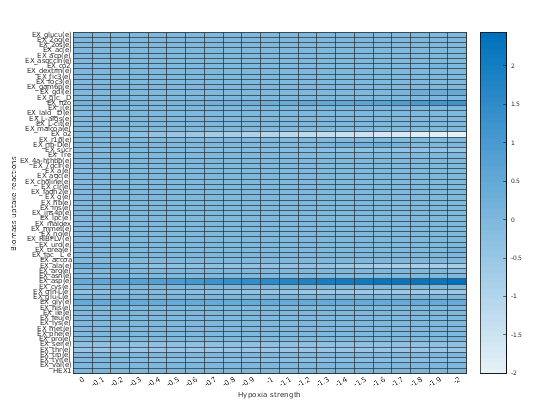

In [50]:
% Change the lower and upper bounds of oxygen uptake.
l_v = 0:-0.1:-2;
res = [];
for i=1:length(l_v);
    model = changeRxnBounds(fly,'EX_o2',l_v(i),'l'); % Set the maximum uptake rate.
    % Optimization.
    FBAsolution = optimizeCbModel(model,'max');
    res = [res FBAsolution.f];
end


ids = find(contains(fly.rxns, 'EX'));
mtr = zeros(length(ids), length(l_v));

for i=1:length(l_v);
    model = changeRxnBounds(fly,'EX_o2',l_v(i),'l'); % Set the maximum uptake rate.
    % Optimization.
    FBAsolution = optimizeCbModel(model,'max');
    % Recording.
    mtr(:, i) = FBAsolution.v(ids);
end

xvalues = l_v;
yvalues = fly.rxns(ids);
h = heatmap(xvalues,yvalues,mtr);

% h.Title = 'T-Shirt Orders';
h.XLabel = 'Hypoxia strength';
h.YLabel = 'Biomass uptake reactions';
% xl = xlabel(h, 'FontSize', 100);
% get(h)
set(h, 'FontSize', 5) 
% modelConstrained.mets(244)

% check the biomass equation.
% check glycolysis.
% check ASP.
% check medium (investigate the connection between the biomass eq and synthesis)

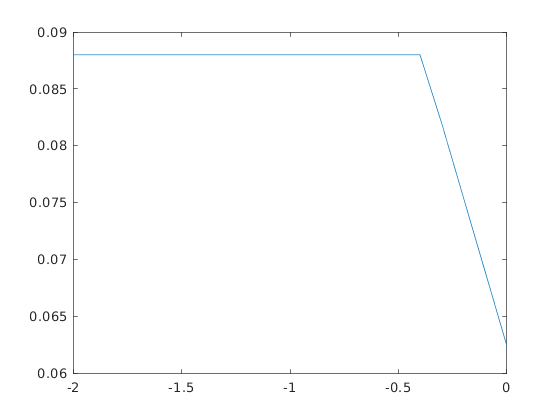

In [27]:
plot(l_v, res)

In [44]:
HEX1_ID = findRxnIDs(fly, 'HEX1')
model = changeRxnBounds(fly,'EX_o2',0,'l');
FBAsolution = optimizeCbModel(model,'max');
FBAsolution.v(HEX1_ID)
OriFBAsolution.v(HEX1_ID)


HEX1_ID =

   156


ans =

    0.0713


ans =

    0.0216



## Increases of nitrogen source by changing Asn uptake rate

In [21]:
% Change the lower and upper bounds of ASN uptake.
l_v = 3:-0.1:-5;
res = [];
for i=1:length(l_v);
    model = changeRxnBounds(fly,'EX_asn(e)',l_v(i),'l'); % Set the maximum uptake rate.
    % Optimization.
    FBAsolution = optimizeCbModel(model,'max');
    res = [res FBAsolution.f];
end

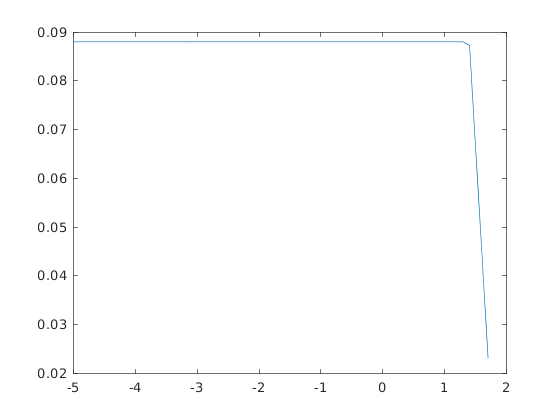

In [22]:
plot(l_v, res)

## Measurements of energy consumption and glycogen/TAG depletion

In [8]:
% Create a demand reaction for measuring ATP.
R1 = 'atp[c] -> ';
modelConstrained = addReaction(model, 'ATPenv', 'reactionFormula', R1);

Error using eval
Undefined function or variable 'model'.



In [45]:
% Search the IDs.
r = modelConstrained.rxns;
rxnIDs = findRxnIDs(modelConstrained, 'ATPenv');
metIDs = findMetIDs(modelConstrained, 'atp[c]');
% Set objective coefficient for the demand reaction.
modelConstrained.rxnNames(rxnIDs);
% modelConstrained.c(rxnIDs) = 1; % -->just maximize ATP % check the paper again...
ATPSID = findRxnIDs(modelConstrained, 'ATPS4r');
BIOMASSID = findRxnIDs(modelConstrained, 'BIOMASS');
modelConstrained.c(ATPSID) = 1;
modelConstrained.c(BIOMASSID) = 0;

In [46]:
% Optimization.
FBAsolution = optimizeCbModel(modelConstrained,'max');
disp('Growth rate:')
disp(FBAsolution.f)
disp('ATP flux:')
disp(FBAsolution.x(rxnIDs))
disp('ATPS flux:')
disp(FBAsolution.x(ATPSID))

% Estimate the concentration of ATP at steady state.
tmp = modelConstrained.S;
emp = zeros(size(tmp));
emp(tmp>0) = tmp(tmp>0);
x = abs(emp)*FBAsolution.v;
atpcID = findMetIDs(modelConstrained, 'atp[c]');
glycogencID = findMetIDs(modelConstrained, 'glycogen[c]');
tagcID = findMetIDs(modelConstrained, 'tag[c]');

disp('ATP concentration estimation in cytosol (by calculating S*v=b):')
disp(x(atpcID))
disp('Flux for the reaction "atp[c]->":')
disp(FBAsolution.v(364))
disp('Glycogen concentration estimation in cytosol (by calculating S*v=b):')
disp(x(glycogencID))
disp('TAG concentration estimation in cytosol (by calculating S*v=b):')
disp(x(tagcID))
% check b and use other method to calculate con.(absolute value in S)

Growth rate:
  598.5755

ATP flux:
     0

ATPS flux:
  598.5755

ATP concentration estimation in cytosol (by calculating S*v=b):
   1.8069e+03

Flux for the reaction "atp[c]->":
     0

Glycogen concentration estimation in cytosol (by calculating S*v=b):
     0

TAG concentration estimation in cytosol (by calculating S*v=b):
     0



In [10]:
del_genes = {'CG3861'; 'CG4001'; 'CG5362'; 'CG10160'}; % kdn (34), pfk(149), mdh(41), ldh(20)
del_rxns = {'CS'; 'PFK'; 'MDH'; 'LDH_L'};

In [11]:
[grRatio, grRateKO, grRateWT, hasEffect, delRxns,...
fluxSolution] = singleGeneDeletion(fly, 'FBA', del_genes);
rate = [grRateKO;grRateWT];
name = del_rxns;
name{length(del_rxns)+1,1} = 'WT';
T = table(name,rate);
disp('Gene deletions:')
disp(T)

Single gene deletion analysis in progress ...
25%     [..........                             50%     [....................                   75%     [..............................         100%    [........................................]
Gene deletions:
     name        rate  
    _______    ________

    'CS'       0.087995
    'PFK'      0.087995
    'MDH'      0.087995
    'LDH_L'    0.087995
    'WT'       0.087995



In [23]:
[grRatio, grRateKO, grRateWT, hasEffect, delRxns,...
fluxSolution] = singleRxnDeletion(fly, 'FBA', del_rxns);
rate = [grRateKO;grRateWT];
name = del_rxns;
name{length(del_rxns)+1,1} = 'WT';
T = table(name,rate);
disp('Reaction deletions:')
disp(T)
%check the biomass in medium like the paper used

Single reaction deletion analysis in progress ...
25%     [..........                             50%     [....................                   75%     [..............................         100%    [........................................]
Reaction deletions:
     name         rate    
    _______    ___________

    'CS'          0.062489
    'PFK'      -1.3365e-12
    'MDH'         0.062489
    'LDH_L'              0
    'WT'          0.087995



In [13]:
find(contains(modelConstrained.mets, 'glyco'))
modelConstrained.mets(105)
find(contains(lower(modelConstrained.mets), 'tag'))
modelConstrained.mets(244)


ans =

   105
   232


ans =

  1x1 cell array

    {'glycogen[c]'}


ans =

   244


ans =

  1x1 cell array

    {'tag[c]'}



In [14]:
modelConstrained.rules(34)
modelConstrained.rules(149)
modelConstrained.rules(41)


ans =

  1x1 cell array

    {'x(2) | x(1)'}


ans =

  1x1 cell array

    {'x(37) | x(38)'}


ans =

  1x1 cell array

    {'x(20) | x(21) | x(23) | x(22) | x(25) | x(24)'}



In [39]:
find(contains(lower(modelConstrained.rxnNames), 'hex'))
n = 156
modelConstrained.rxnNames(n)
modelConstrained.rxns(n)
%Serine hydroxymethyl transferase


ans =

   156


n =

   156


ans =

  1x1 cell array

    {'hexokinase (D-glucose:ATP)'}


ans =

  1x1 cell array

    {'HEX1'}



In [7]:
outputFormatOK = changeCbMapOutput('matlab');
map=readCbMap('ecoli_core_map');
map
% options.zeroFluxWidth = 0.1;
% options.rxnDirMultiplier = 10;
% drawFlux(map, model, FBAsolution.v, options);


map = 

  struct with fields:

               shapeType: {3x1 cell}
                shapePos: [3x2 double]
               shapeSize: [3x2 double]
              shapeStyle: {3x1 cell}
          shapeThickness: [3x1 double]
              shapeColor: [3x3 double]
                    text: {0x1 cell}
                textFont: {0x1 cell}
                 textPos: [0x2 double]
                textSize: [0x1 double]
             molPosition: [2x221 double]
                molIndex: [221x1 double]
                 molName: {221x1 cell}
         molAbbreviation: {221x1 cell}
             molLabelPos: [221x2 double]
                molPrime: {221x1 cell}
          molCompartment: [221x1 double]
             rxnPosition: [2x454 double]
        rxnLabelPosition: [2x454 double]
                rxnIndex: [454x1 double]
              connection: [476x2 double]
           connectionAbb: {476x1 cell}
          connectionName: {476x1 cell}
    connectionReversible: [477x1 double]

